              precision    recall  f1-score   support

           0       0.90      0.86      0.88       110
           1       0.79      0.84      0.82        69

    accuracy                           0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.86      0.85      0.86       179

Optimized Model Accuracy: 0.8547
Submission file created: submission_file.csv


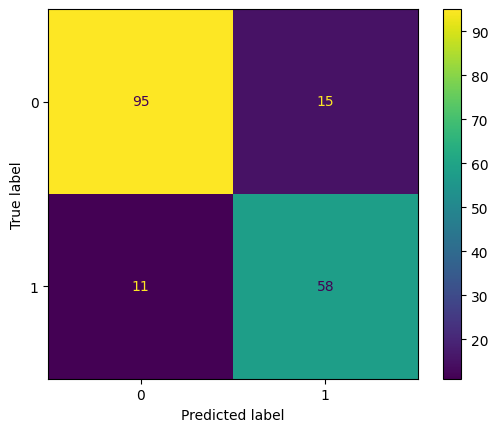

In [43]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.impute import SimpleImputer
import numpy as np

# Load dataset
dataset_url = 'https://github.com/robitussin/CCMACLRL_EXERCISES/blob/f5fdfba1aabbbafcf2fe49ca6e1c8f92f69d1458/datasets/titanic/train.csv?raw=true'
df = pd.read_csv(dataset_url)

# Select features and target
df = df[['Survived', 'Age', 'Sex', 'Pclass', 'Fare', 'SibSp', 'Parch', 'Name']]

# Extract title from names
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
df.drop('Name', axis=1, inplace=True)

# Impute missing values in 'Age'
imputer = SimpleImputer(strategy='mean')
df['Age'] = imputer.fit_transform(df[['Age']])

# Create a new feature 'FamilySize'
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Create Fare per person feature
df['Fare_Per_Person'] = df['Fare'] / df['FamilySize']

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Title'], drop_first=True)

# Drop unnecessary columns
df.drop(['SibSp', 'Parch', 'Fare'], axis=1, inplace=True)

# Split data into features (X) and target (y)
X = df.drop('Survived', axis=1)
y = df['Survived']

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize Logistic Regression with GridSearchCV for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 200, 300, 500]
}

grid = GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'), param_grid, cv=5)
grid.fit(x_train, y_train)

# Best model
model = grid.best_estimator_

# Model evaluation
y_pred = model.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))

# Print model score
print(f'Optimized Model Accuracy: {model.score(x_test, y_test):.4f}')

# Test dataset (dt)
test_url = 'https://github.com/robitussin/CCMACLRL_EXERCISES/blob/f5fdfba1aabbbafcf2fe49ca6e1c8f92f69d1458/datasets/titanic/test.csv?raw=true'
dt = pd.read_csv(test_url)

# Same feature engineering for test set
dt = dt[['PassengerId', 'Name', 'Sex', 'Age', 'Pclass', 'Fare', 'SibSp', 'Parch']]
dt['Title'] = dt['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
dt['Title'] = dt['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dt['Title'] = dt['Title'].replace(['Mlle', 'Ms'], 'Miss')
dt['Title'] = dt['Title'].replace('Mme', 'Mrs')
dt.drop('Name', axis=1, inplace=True)

# Impute missing values in 'Age' and 'Fare'
dt['Age'] = imputer.transform(dt[['Age']])
dt['Fare'].fillna(dt['Fare'].median(), inplace=True)

# Create 'FamilySize' and 'Fare_Per_Person'
dt['FamilySize'] = dt['SibSp'] + dt['Parch'] + 1
dt['Fare_Per_Person'] = dt['Fare'] / dt['FamilySize']

# One-hot encode categorical variables
dt = pd.get_dummies(dt, columns=['Sex', 'Pclass', 'Title'], drop_first=True)

# Drop unnecessary columns
dt.drop(['SibSp', 'Parch', 'Fare'], axis=1, inplace=True)

# Scale features
dt_scaled = scaler.transform(dt.drop('PassengerId', axis=1))

# Predict survival for the test dataset
y_test_pred = model.predict(dt_scaled)

# Prepare the submission
submission_df = pd.DataFrame({
    'PassengerId': dt['PassengerId'],
    'Survived': y_test_pred
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission_file.csv', index=False)
print("Submission file created: submission_file.csv")


In [26]:
model.score(x_test, y_test)

0.8547486033519553